# Chapter 4 - Logistic Regression

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/jtooates/mlnb_public.git &> /dev/null
    !mv mlnb_public/* . &> /dev/null

In [2]:
%run Chapter\ 4\ Utilities.ipynb

In chapter 2 we explored the Perceptron Learning Algorithm (PLA), which learns a weight vector ${\bf w}$ such that ${\tt sign}({\bf w} \cdot {\bf x_i}) = y_i$ for all instances $({\bf x_i}, y_i)$ in a linearly separable training set.  Recall that the output of the Perceptron for a new ${\bf x}$ is either ${\tt -1}$ or ${\tt +1}.$  If the training set contains loan applications (i.e., the values of ${\bf x_i}$) and whether the applicant paid off their loan on time (i.e., the values of $y_i$), the Perceptron will tell you if a new applicant will (${\tt +1}$) or won't (${\tt -1}$) pay off their loan on time.  If the training set contains symptoms and whether the patient had appendicitis, the Perceptron will tell tell you if the patient needs or does not need an appendectomy. 

In this chapter we'll explore the Logistic Regression (LR) algorithm, which also learns weight vectors but is a probabilistic classifier.  Rather than producing a class label as output, LR produces probabilities of class labels, which is often very useful information.  To manage risk, a loan officer may approve larger loans for applicants that have a 99% chance of paying back their loans on time compared to those who have an 80% chance of paying back their loans on time.  Similarly, a doctor would not want to proceed with an appendectomy if the chance of needing one is only 70%, but would order more tests to get more certainty.

Logistic Regression is a useful algorithm in its own right, and learning about it will introduce a number of basic building blocks and ideas that we'll see in later chapters on neural networks.  The remainder of this chapter is organized as follows:
* Section 4.1 describes the problem that LR solves and how it produces probabilities as opposed to class labels.
* Section 4.2 is a quick review of a few key concepts from probability theory that are needed to derive the LR algorithm.
* Section 4.3 applies the machinery of gradient descent from chapter 3 to derive the LR update rule, introducing the cross-entropy loss for probabilistic classifiers.  This section contains a lot of math related to deriving the gradient.  It is perfectly OK to read the first part that decribes the function to be optimized and the last part that shows final update rule and explains why it makes intuitive sense.
* Section 4.4 contains an implementation of the algorithm, shows the behavior on a sample dataset, and identifies some practical issues that need attention when using LR on real data.
* Section 4.5 explains how to adapt LR to deal with more than two classes.
* Section 4.6 has a few closing thoughts.

## 4.1 From Weight Vectors to Probabilities

LR takes as input, just like the PLA, a training set with feature vectors ${\bf x} \in \mathbb{R}^n$.  If a bias is needed, which is typically the case, we'll assume that one of the features is a constant value (e.g., $x_0 = 1$).  Like the Perceptron, LR is a binary classifier.  To make the math easier later on the class label will be either ${\tt 0}$ or ${\tt 1}$.

Given a training set, LR learns a weight vector ${\bf w} \in \mathbb{R}^n$ that is used to compute the probability that the correct class label is either ${\tt 0}$ or ${\tt 1}$.  Let $p^1_{\bf w}({\bf x})$ denote the probability that the true class label for input ${\bf x}$ is ${\tt 1}$.  Likewise, $p^0_{\bf w}({\bf x})$ denotes the probability that the true class label for input ${\bf x}$ is ${\tt 0}$.  Because they are probabilities, it must be the case that $0 \leq  p^1_{\bf w}({\bf x}) \leq 1$ and likewise for $p^0_{\bf w}({\bf x})$.  And because there are only two possible class labels it must be the case that $p^1_{\bf w}({\bf x}) + p^0_{\bf w}({\bf x}) = 1$.

Note that both $p^1_{\bf w}$ and $p^0_{\bf w}$ depend on ${\bf w}$, the learned weight vector.  Different weight vectors will produce different probabilities for the same input ${\bf x}$.  Two questions immediately come to mind.  First, how do weight and input vectors get turned into probabilities?  Second, what loss function does LR minimize in gradient descent to find a "good" weight vector?  We'll answer the first question now and provide intuition for the second, with a mathematically precise answer waiting until section 4.3.

Recall that the PLA computed the value of ${\bf w} \cdot {\bf x}$ and handed that value to the ${\tt sign}()$ function to determine the class label.  That function is shown below, with ${\bf w} \cdot {\bf x}$ on the horizontal axis and $y$ on the vertical axis.

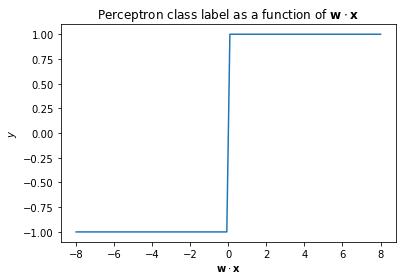

In [3]:
plot_sign()

Note that the sign function is a step.  It doesn't matter if ${\bf w} \cdot {\bf x}$ is 0.1 or 1 or 10.  As long as that value is positive, the instance is classified as positive.  Likewise, it doesn't matter if ${\bf w} \cdot {\bf x}$ is -0.1 or -1 or -10.  As long as that value is negative, the instance is classified as negative.

Logistic Regression computes the value of ${\bf w} \cdot {\bf x}$. But instead of passing it to the ${\tt sign}$ function like the PLA, the *logistic* or *sigmoid* function is used, which is denoted $\sigma$ and has the following form:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

We'll explain where this function comes from in a moment, but for now we'll explore some nice properties that it has as shown in the plot below.  

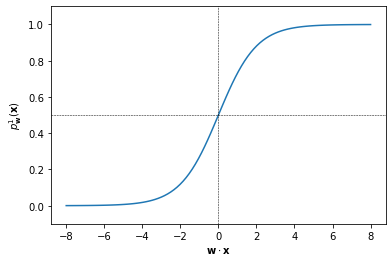

In [4]:
plot_logistic(generic = False)

The horizontal axis is ${\bf w} \cdot {\bf x}$, just like in the previous plot.  But now the vertical axis is not the class label, it is the *probability* that the class label for instance ${\bf x}$ is ${\tt 1}$ given the current weight vector.  That is, the vertical axis is:
    
$$
p^1_{\bf w}({\bf x}) = \frac{1}{1 + e^{-{\bf w} \cdot {\bf x}}}
$$

Gone is the step behavior of the ${\tt sign()}$ function; $p^1_{\bf w}({\bf x})$ varies smoothly as a function of ${\bf w} \cdot {\bf x}.$  The sigmoid function is sometimes called a "squashing" function because its domain is the entire real line (i.e., possible values of ${\bf w} \cdot {\bf x}$) which is mapped or squashed into the range $[0, 1]$, allowing us to interpret its output as a probability.

Suppose ${\bf w} \cdot {\bf x} = 0$.  Then it is the case that:

\begin{eqnarray*}
p^1_{\bf w}({\bf x}) & = & 1 / (1 + e^{-{\bf w} \cdot {\bf x}} ) \\
& = & 1/(1 + e^0) \\
& = & 1/(1 + 1) \\
& = & 0.5
\end{eqnarray*}

And because $p^1_{\bf w}({\bf x}) + p^0_{\bf w}({\bf x}) = 1$, it is also the case that $p^0_{\bf w}({\bf x}) = 0.5$.  That is, when ${\bf w} \cdot {\bf x} = 0$ the instance is equally likely to belong to either class.  This is reminiscent of the Perceptron where points for which ${\bf w} \cdot {\bf x} = 0$ were on the separating hyperplane.

When ${\bf w} \cdot {\bf x} > 0$ the value of $p^1_{\bf w}({\bf x}) > 0.5$ as is clear from the plot above, and it is more likely that the correct class label is ${\tt 1}$ as opposed to ${\tt 0}$.  In contrast to the Perceptron, which doesn't care about the magnitude of ${\bf w} \cdot {\bf x}$, for LR the larger the value of ${\bf w} \cdot {\bf x}$ the more certain the classifier becomes.  When ${\bf w} \cdot {\bf x} = 0.1$, $p^1_{\bf w}({\bf x}) = 0.52$.  That probability becomes $0.73$ when ${\bf w} \cdot {\bf x} = 1$ and $0.99$ when ${\bf w} \cdot {\bf x} = 10$.  The larger the value of ${\bf w} \cdot {\bf x}$ the higher the probability that the instance belongs to class ${\tt 1}$ and the lower the probability that the instance belongs to class ${\tt 0}$.

When ${\bf w} \cdot {\bf x} < 0$ the value of $p^1_{\bf w}({\bf x}) < 0.5$ as is clear from the plot above, and it is more likely that the correct class label is ${\tt 0}$ as opposed to ${\tt 1}$.  When ${\bf w} \cdot {\bf x} = -0.1$, $p^1_{\bf w}({\bf x}) = 0.48$.  That probability becomes $0.27$ when ${\bf w} \cdot {\bf x} = -1$ and $0.01$ when ${\bf w} \cdot {\bf x} = -10$.  The more negative the value of ${\bf w} \cdot {\bf x}$ the higher the probability that the instance belongs to class ${\tt 0}$ and the lower the probability that the instance belongs to class ${\tt 1}$.

But where did the sigmoid function come from?  Surely there are other functions that squash the real line into the range $[0, 1]$ that would work just as well.  It turns out that the sigmoid is the only function for which the log odds are linear.  Let's unpack that.

Recall that the *odds* of something happening is the ratio of the probability of that thing happening to the probability of it not happening.  If $p$ is the probability of your team winning the game, then the odds of them winning is just $p/(1-p)$.  When they have a 50-50 chance, the odds are 1.  If they are more likely to win than lose then the odds are greater than one, and if they are more likely to lose than win the odds are less than 1.

What does it mean for the log odds to be linear in the context of LR?  Mathematically it means the following:

$$
\ln\left( \frac{p^1_{\bf w}({\bf x})}{p^0_{\bf w}({\bf x})} \right) =  {\bf w} \cdot {\bf x}
$$

In words, the log of the odds of class ${\tt 1}$ being the correct class is a linear function of the instance ${\bf x}$.  A unit change in one of the feature values ($x_i$) leads to a constant change in the log odds where the magnitude of that change is controlled by the magnitude of the corresponding weight ($w_i$).

As shown below, requiring the log odds to be a linear function of ${\bf x}$ leads directly to the sigmoid as the representation for $p^1_{\bf w}({\bf x})$, which is abbreviated as $p^1_{\bf w}$ to keep things concise.  The derivation starts with the requirement of linear log odds, and then exponentiates both sides to get rid of the log.  From there it's just algebra, including the last step where the top and bottom of the right-hand side are multiplied by $1/e^{{\bf w} \cdot {\bf x}}$ to get to the form of the sigmoid introduced earlier in this chapter.

\begin{eqnarray*}
\ln(p^1_{\bf w}/p^0_{\bf w}) & = & {\bf w} \cdot {\bf x} 
\tag*{Linear log odds}
\\[0.2cm]
p^1_{\bf w}/p^0_{\bf w} & = & e^{{\bf w} \cdot {\bf x}} 
\tag*{Exponentiate both sides} 
\\[0.2cm]
p^1_{\bf w}/(1 - p^1_{\bf w}) & = & e^{{\bf w} \cdot {\bf x}} 
\tag*{Rewrite $p^0_{\bf w}$ in terms of $p^1_{\bf w}$}
\\[0.2cm]
p^1_{\bf w} & = & (1 - p^1_{\bf w}) e^{{\bf w} \cdot {\bf x}} 
\tag*{Solve for $p^1_{\bf w}$}
\\[0.2cm]
p^1_{\bf w} & = & e^{{\bf w} \cdot {\bf x}} - p^1_{\bf w} e^{{\bf w} \cdot {\bf x}} \\[0.2cm]
p^1_{\bf w} + p^1_{\bf w} e^{{\bf w} \cdot {\bf x}} & = & e^{{\bf w} \cdot {\bf x}} \\[0.2cm]
p^1_{\bf w}(1 + e^{{\bf w} \cdot {\bf x}}) & = & e^{{\bf w} \cdot {\bf x}} \\[0.2cm]
p^1_{\bf w} & = & \frac{e^{{\bf w} \cdot {\bf x}}}{1 + e^{{\bf w} \cdot {\bf x}}}
\tag*{Divide top and bottom by $e^{{\bf w} \cdot {\bf x}}$}
\\[0.2cm]
p^1_{\bf w} & = & \frac{1}{1 + e^{-{\bf w} \cdot {\bf x}}} 
\end{eqnarray*}

So where are we now?  We know that Logistic Regression is a probabilistic binary classifer.  Given a training set it learns a weight vector, and that weight vector is combined with new instances via the sigmoid function to get the probability that they belong to class ${\tt 1}$ or ${\tt 0}$.  We use the sigmoid because it makes the log odds of class ${\tt 1}$ linear in the feature vector.

But how does LR arrive at a weight vector?  What makes one weight vector better than another?  Intuitively, LR tries to maximize the probability of the correct class label.  If $({\bf x_i}, y_i = 1)$ is a training instance, the algorithm will adjust the weight vector to increase $p^1_{\bf w}({\bf x_i})$ and thus decrease $p^0_{\bf w}({\bf x_i})$.  If $({\bf x_i}, y_i = 0)$ is a training instance, the weight vector will change to increase $p^0_{\bf w}({\bf x_i})$ and thus decrease $p^1_{\bf w}({\bf x_i})$. The final weight vector will reflect the push and pull of all of the instances in the training set.  This is an example of maximum likelihood estimation, which is covered in the next section.

We'll make the intuition above formal in section 4.3, right after a very quick review of a few concepts from probability needed to derive the LR update rule.

## 4.2 Just Enough Probability to Derive the Update Rule

Because Logistic Regression is a probabilistic classifier, we'll use a few simple concepts from probability theory during the derivation of it's update rule.  This section contains a very quick refresher for those concepts.

### Random Variables

A **random variable** is a variable whose value is the result of some process or event that involves uncertainty.  A **discrete random variable** is one that can take on a finite number of distinct values, like ${\tt heads}$ or ${\tt tails}$ representing the outcome of a coin flip or numbers in $\{1, 2, 3, 4, 5, 6\}$ representing the outcome of a die roll.  A **continuous random variable** is one that can take on an infinite number of distinct values, typically subsets of the real line, like daily rainfall amounts or closing prices of financial securities.

For discrete random variable $X$, let $p(X = x)$ denote the probability that $X$ takes on value $x$.  It must be the case that $0 \leq p(X = x) \leq 1$ for all $x$ and that the sum of $p(X = x)$ over all $x$ is 1.  If $X$ represents the outcome of a fair coin flip then $p(X = {\tt heads}) = p(X = {\tt tails}) = 0.5$ and $p(X = {\tt heads}) + p(X = {\tt tails}) = 1$.

A **joint probability** is the probability of two or more random variables taking on specific values at the same time.  If $X$ represents the outcome of a coin flip and $Y$ represents the outcome of a die roll, then $p(X = {\tt heads}, Y = {\tt 5})$ is the probability that the coin comes up ${\tt heads}$ and the die comes up ${\tt 5}$.

Two random variables are **independent** if knowing the value of one gives you no information about the value of the other.  Suppose I ask you what the probability is that a fair die will come up ${\tt 5}$.  You would say $1/6$.  If I tell you that the coin came up ${\tt heads}$ and ask the same question, you'll still say $1/6$ because the coin flip and the die roll do not influence each other, they are independent.

Now suppose I ask you what the probability is that a person chosen at random in the US is above the median age.  You'd clearly answer 0.5 because, by definition, half of the people are older than the median and half are younger.  But if I tell you that the person is retired your estimate of the probability that they are above the median age will go up, perhaps significantly.  That's because age and retirement status are dependent.  The younger you are the less likely you are to be retired and the older you are the more likely you are to be retired.

More formally, two random variables are independent if and only if the joint probability is equal to the product of the individual probabilities:

$$p(X = x, Y = y) = p(X = x) p(Y = y)$$

If you want to know $p(X = {\tt heads}, Y = {\tt 5})$ it suffices to compute $p(X = {\tt heads}) p(Y = {\tt 5})$ because coin flips are die rolls are independent.  But it is *not* the case that $p(X = {\tt above\ median\ age}, Y = {\tt retired})$ is equal to $p(X = {\tt above\ median\ age}) p(Y = {\tt retired})$ because age and retirement status are not independent.

In the two variable case, a **conditional probability** is the probability that one of the variables takes on a specific value given the value of the other and is written $p(X = x | Y = y)$.  If you're in a world where you've observed the value of $Y$ to be $y$, what is the probability that $X = x$?  For example, $p(X = {\tt above\ median\ age} | Y = {\tt retired})$ is the probability that a person who is known to be retired is above the median age. That is the fraction of retired people who are above the median age.

The conditional and joint probabilities are related by the following equality known as the **chain rule of probability**:

$$p(X = x, Y = y) = p(X = x | Y = y) p(Y = y)$$

If $X$ and $Y$ are independent, then $p(X = x | Y = y) = p(X = x)$.  That's another way of saying that knowing the value of $Y$ does not change your mind about the probability of $x$ being the value of $X$.  We show that mathematically below, where the second line follows from the first due to idendendence of $X$ and $Y$, and the third line follows from the second after dividing both sides by $p(Y = y)$:

\begin{eqnarray*}
p(X = x, Y = y) & = & p(X = x | Y = y) p(Y = y) \\[0.2cm]
p(X = x) p(Y = y) & = & p(X = x | Y = y) p(Y = y) \\[0.2cm]
p(X = x) & = & p(X = x | Y = y)
\end{eqnarray*}

### Maximum Likelihood Estimation

Suppose you have a biased coin that comes up heads with unknown probability $\theta$.  You flip the coin 10 times and get 7 heads and 3 tails.  What value would you assign to $\theta$?  The obvious answer is $7/10$, the number of heads divided by the number of flips.  It turns out that this obvious answer is the **maximum likelihood estimate** (MLE) of $\theta$.  That is, it is the value that maximizes the probability of the data that you observed.

Suppose the sequence of coin flips was $D = \{{\tt H, H, T, H, H, H, H, T, T, H}\}$.  Let $L(D; \theta)$ denote the likelihood of the data, the probability of observing $D$ given a specific value of $\theta$, and let $p_\theta()$ denote a probability given a specific value of $\theta$:

\begin{eqnarray*}
L(D; \theta) = p_\theta({\tt H, H, T, H, H, H, H, T, T, H})
\end{eqnarray*}

Because the coin flips are independent of one another, we can rewrite the joint probability as a product of individual probabilities and simplify:

\begin{eqnarray*}
L(D; \theta) & = & p_\theta({\tt H}) p_\theta({\tt H}) p_\theta({\tt T}) p_\theta({\tt H}) p_\theta({\tt H}) p_\theta({\tt H}) p_\theta({\tt H}) p_\theta({\tt T}) p_\theta({\tt T}) p_\theta({\tt H}) \\
& = & p_\theta({\tt H})^7 p_\theta({\tt T})^3 \\
& = & p_\theta({\tt H})^7 (1 - p_\theta({\tt H}))^3 \\
& = & \theta^7 (1 - \theta)^3
\end{eqnarray*}

The MLE for $\theta$ is the value that maximizes $L(D; \theta) = \theta^7 (1 - \theta)^3$, i.e., the probability of seeing 7 heads and 3 tails in 10 flips.  The plot below shows $L(D; \theta)$ on the vertical axis as a function of $\theta$ on the horizontal axis.  Note that the maximum lies at $\theta = 0.7$, which accords with intuition.

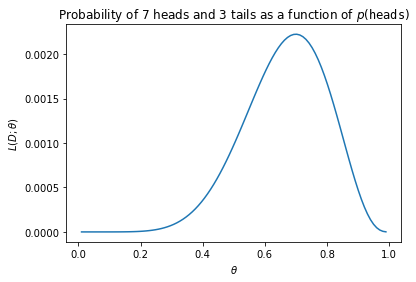

In [5]:
plot_MLE()

We're finally ready to derive the update rule for Logistic Regression!

## 4.3 Deriving the Logistic Regression Update Rule

As described in Chapter 3, gradient descent is machine learning's hammer and it's looking for nails.  In this section we frame Logistic Regression in those terms which, as by now you know, involves defining a suitable loss function and computing the partial derivatives of that loss function with respect to the learnable parameters, i.e., the weights.  We'll take a slightly different approach here by first deriving the likelihood function and then computing the partial derivatives of that function with respect to the weights so that it can be **maximized** with **gradient ascent** (i.e., by adding the gradient to update the parameters as opposed to subtracting it).  But it's trivial to use standard gradient descent by treating the negative of the likelihood function as a loss to be minimized.

This is a long section with lots of math.  If you want to skip to the end for the punchline, which is the update rule that we'll use for implementing Logistic Regression in section 4.4, that's OK.

### Deriving the Likelihood Function

As usual, we'll assume a training set of $m$ instances $D = \{({\bf x_1}, y_1), \ldots, ({\bf x_m}, y_m))$ with ${\bf x_i} \in \mathbb{R}^n$.  For LR, as noted above, $y_i \in \{0, 1\}$.  Our goal is to find the **maximum likelihood** weight vector ${\bf w} \in \mathbb{R}^n$:

\begin{eqnarray*}
\underset{{\bf w}}{\arg\max} \ L(D; {\bf w}) & = & \underset{{\bf w}}{\arg\max} \ p_{\bf w}(D) 
\tag*{Definition of MLE} \\
& = & \underset{{\bf w}}{\arg\max} \ p_{\bf w}(({\bf x_1}, y_1), \ldots, ({\bf x_m}, y_m)) 
\tag*{Expand $D$}\\
& = & \underset{{\bf w}}{\arg\max} \ \prod_{i} p_{\bf w}({\bf x_i}, y_i) 
\tag*{Independence} \\
& = & \underset{{\bf w}}{\arg\max} \ \ln \left( \prod_{i} p_{\bf w}({\bf x_i}, y_i) \right)
\tag*{Log is monotonic} \\
& = & \underset{{\bf w}}{\arg\max} \ \sum_{i} \ln \left( p_{\bf w}({\bf x_i}, y_i) \right)
\tag*{Log of product}
\end{eqnarray*}

We're looking for the weight vector that makes the observed data as likely as possible where that data consists of $m$ training instances.  Because the instances are independent the joint probability of the entire dataset can be rewritten as a product of probabilities of the individual instances.  For example, the fact that someone showed up at the bank yesterday applying for a loan that they will not pay off on time has no causal impact on my financial status (i.e., my ${\bf x}$) or whether I'll pay my loan off on time (i.e., my $y$).

This is all leading up to computing derivatives with respect to weights, and derivatives of products are painful.  Taking the log makes that problem go away because the log of a product becomes the sum of the logs of the individual terms.  This new expression is called the **log likelihood**.  Note that the log is always applied to probabilities, numbers between 0 and 1.  The plot below shows what the log looks like in that region applied to some probability $p$.  The log is monotone, as $p$ increases so does $\ln(p)$, so the ${\tt argmax}$ applied to a raw probability or the log of that probability will return the same value.

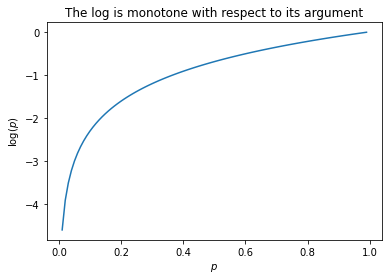

In [6]:
plot_ln()

Let's keep working on the last expression above, which seeks the weight vector that maximizes the sum of the log of the probability of all the training instances.  The first step below is to rewrite $\ln \left( p_{\bf w}({\bf x_i}, y_i) \right)$ as $\ln \left( p_{\bf w}(y_i|{\bf x_i}) p_{\bf w}({\bf x_i})\right)$ using the chain rule.  That can be expanded into $\ln(p_{\bf w}(y_i|{\bf x_i})) + \ln(p_{\bf w}({\bf x_i}))$.  

The second term is the prior probability of ${\bf x_i}$, or how probable it is to observe that particular attribute vector.  It could be the case that all attribute vectors are equally likely or, more realistically, it could be the case that some are more probable than others.  Regardless, those probabilities are independent of the weight vector.  Nature doesn't care what Logistic Regression does, she just offers up $(\bf x, y)$ pairs for it to learn from.  The $\ln(p_{\bf w}({\bf x_i}))$ terms become constants that can be ignored inside the ${\tt argmax}$.

That just leaves $\ln(p_{\bf w}(y_i|{\bf x_i}))$, which is the log of the probability that the model assigns to the *correct* class label for the $i^{th}$ instance given the current weight vector.  If $y_i = 1$ that probability is $p_{\bf w}^1({\bf x_i})$, and if $y_i = 0$ that probability is $p_{\bf w}^0({\bf x_i})$.  That's written below in the last line as an if-then rule.

\begin{eqnarray*}
\underset{{\bf w}}{\arg\max} \ \sum_{i} \ln \left( p_{\bf w}({\bf x_i}, y_i) \right) & = & \underset{{\bf w}}{\arg\max} \ \sum_{i} \ln \left( p_{\bf w}(y_i|{\bf x_i}) p_{\bf w}({\bf x_i})\right) 
\tag*{Chain rule} \\
& = & \underset{{\bf w}}{\arg\max} \sum_{i} \ln \left( p_{\bf w}(y_i|{\bf x_i}) \right) 
\tag*{${\bf x_i}$ independent of ${\bf w}$}
\\ 
& = & \underset{{\bf w}}{\arg\max} \sum_{i} \begin{cases}
    \ln(p_{\bf w}^1({\bf x_i}))& \text{if } y_i = 1\\
    \ln(p_{\bf w}^0({\bf x_i}))& \text{if } y_i = 0\\
\end{cases}
\end{eqnarray*}

The if-then rule in the line above is problematic for the purposes of taking partial derivatives.  A neat way around that is to use the cross-entropy form to turn the rule into an equation that easily admits gradient descent.  That form is shown below:

$$
\ln(p_{\bf w}(y_i|{\bf x_i})) = y_i \ln(p_{\bf w}^1({\bf x_i})) + (1 - y_i)
\ln(1 - p_{\bf w}^1({\bf x_i}))
$$        

If $y_i = 1$ the expression above simplifies as follows:

\begin{eqnarray*}
\ln(p_{\bf w}(y_i = 1|{\bf x_i})) & = & 1 * \ln(p_{\bf w}^1({\bf x_i})) + (1 - 1) *
\ln(1 - p_{\bf w}^1({\bf x_i})) \\
& = & \ln(p_{\bf w}^1({\bf x_i})) + 0 * \ln(1 - p_{\bf w}^1({\bf x_i})) \\
& = & \ln(p_{\bf w}^1({\bf x_i}))
\end{eqnarray*}

Similarly, when $y_i = 0$ the expression simplifies to $\ln(1 - p_{\bf w}^1({\bf x_i}))$.  The cross entropy form gives us an equation that is differentiable and behaves exactly like the rule-based form!

We've finally arrived at the function that Logisic Regression will optimize:

$$
L(D; {\bf w}) = \sum_i \left[y_i \ln(p_{\bf w}^1({\bf x_i})) + (1 - y_i)
\ln(1 - p_{\bf w}^1({\bf x_i})) \right]
$$        

Because the goal is to maximize the log likelihood we'll use gradient ascent, but it's easy to use gradient descent to minimize the negative log likelihood, i.e., $-L(D; {\bf w})$.

### Maximizing the Likelihood with Gradient Ascent

All that's left is to compute the gradient of $L(D; {\bf w})$, i.e., the partial derivatives with respect to the individual weights.  Recall that the generic weight update rule for gradient descent given learning rate $\alpha$ and loss function $L$ is:

$$
{\bf w} = {\bf w} - \alpha \nabla L
$$

Iterating between computing $\nabla L$ and updating the weights minimizes $L$.  All that's required to maximimize $L$ is to make the update additive:

$$
{\bf w} = {\bf w} + \alpha \nabla L
$$

Now we're walking uphill rather than downhill.

We'll need to remember two facts from differential calculus.  The first is about the derivative of the log function:

$$
\frac{d \ln(x)}{dx} = \frac{1}{x} dx
$$

The second is about the derivative of exponentials:

$$
\frac{d e^x}{dx} = e^x dx
$$


Let's start taking the derivative of the log likelihood with respect to an arbitrary weight $w_j$:

\begin{eqnarray*}
\frac{\partial}{\partial w_j} L(D; {\bf w}) & = & \frac{\partial}{\partial w_j} \sum_i \left[ y_i \ln(p_{\bf w}^1({\bf x_i})) + (1 - y_i)
\ln(1 - p_{\bf w}^1({\bf x_i})) \right] \\[0.25cm]
& = & \sum_i \left[ \frac{y_i}{p_{\bf w}^1({\bf x_i})} \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) + \frac{(1 - y_i)}{(1 - p_{\bf w}^1({\bf x_i}))} 
\frac{\partial}{\partial w_j} (1 - p_{\bf w}^1({\bf x_i})) \right] \\[0.25cm]
& = & \sum_i \left[ \frac{y_i}{p_{\bf w}^1({\bf x_i})} \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) - \frac{(1 - y_i)}{(1 - p_{\bf w}^1({\bf x_i}))} 
\frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) \right] \\[0.25cm]
& = & \sum_i \left[ \frac{y_i}{p_{\bf w}^1({\bf x_i})} - \frac{(1 - y_i)}{(1 - p_{\bf w}^1({\bf x_i}))} 
\right] \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) \\[0.25cm]
& = & \sum_i \left[ \frac{y_i (1 - p_{\bf w}^1({\bf x_i})) - (1 - y_i) p_{\bf w}^1({\bf x_i})}{p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})} 
\right] \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) \\[0.25cm]
& = & \sum_i \left[ \frac{y_i - p_{\bf w}^1({\bf x_i})}{p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})} 
\right] \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) \\[0.25cm]
\end{eqnarray*}


Now we're ready to compute the partial derivative of $p_{\bf w}^1({\bf x_i})$ with respect to weight $w_j$.  Below, $x_{i,j}$ denotes the $j^{th}$ element of the $i^{th}$ instance's attribute vector.  That element is multiplied by $w_j$ when computing ${\bf w} \cdot {\bf x}$.

\begin{eqnarray*}
\frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) & = &
\frac{\partial}{\partial w_j} \frac{1}{1 + e^{-{\bf w} \cdot {\bf x_i}}} \\[0.2cm]
& = & - \frac{1}{({1 + e^{-{\bf w} \cdot {\bf x_i}}})^2} \frac{\partial}{\partial w_j}
e^{-{\bf w} \cdot {\bf x}} \\[0.2cm]
& = & - \frac{1}{({1 + e^{-{\bf w} \cdot {\bf x_i}}})^2} 
e^{-{\bf w} \cdot {\bf x_i}} \frac{\partial}{\partial w_j} (-{\bf w} \cdot {\bf x_i}) \\[0.2cm]
& = & \frac{e^{-{\bf w} \cdot {\bf x_i}}}{({1 + e^{-{\bf w} \cdot {\bf x_i}}})^2} \ x_{i,j} \\[0.2cm]
& = & \frac{1}{({1 + e^{-{\bf w} \cdot {\bf x_i}}})}
\frac{e^{-{\bf w} \cdot {\bf x_i}}}{({1 + e^{-{\bf w} \cdot {\bf x_i}}})}
\ x_{i,j} \\[0.2cm]
& = & p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})) \ x_{i,j} 
\end{eqnarray*}

The final step is to replace the partial derivative of $p_{\bf w}^1({\bf x_i})$ with respect to $w_j$ in the expression below and simplify:

\begin{eqnarray*}
\frac{\partial}{\partial w_j} L(D; {\bf w}) & = & 
\sum_i \left[ \frac{y_i - p_{\bf w}^1({\bf x_i})}{p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})} 
\right] \frac{\partial}{\partial w_j} p_{\bf w}^1({\bf x_i}) \\[0.25cm]
& = & \sum_i \left[ \frac{y_i - p_{\bf w}^1({\bf x_i})}{p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})} \right] p_{\bf w}^1({\bf x_i}) (1 - p_{\bf w}^1({\bf x_i})) \ x_{i,j} \\[0.25cm]
& = & \sum_i (y_i - p_{\bf w}^1({\bf x_i})) x_{i,j}
\end{eqnarray*}


That was a lot of work to wind up with such a simple expression! But now that we've got it let's see why it makes intuitive sense by considering how it is used in practice.

### Intuition Behind the Update Rule for Logistic Regression

Recall that gradient ascent for Logistic Regression involves iterating between computing the gradient of the log likelihood and taking a step in the direction of the gradient.

$$
{\bf w} = {\bf w} + \alpha \nabla L(D; {\bf w})
$$


Let's focus on a single instance $({\bf x_i}, y_i)$ and a single weight $w_j$, for which the update is shown below.

$$
w_j = w_j + \alpha (y_i - p_{\bf w}^1({\bf x_i})) x_{i,j}
$$

The new value of $w_j$ is the old value plus (because we're doing gradient ascent) a fraction $\alpha$ of the $j^{th}$ term in the gradient of the log likelihood.  Let's consider a couple of cases.

**Case 1:** $y_i = 1$ and $x_{i,j} > 0$

If $y_i = 1$ and $x_{i,j} > 0$, we want $w_j$ to increase.  Why?  Because we want ${\bf w} \cdot {\bf x_i}$ to be as large as possible so we move to the right on the plot of the sigmoid above and $p_{\bf w}^1({\bf x_i})$ gets closer to 1, assigning a higher probability than before the update to the correct class label.

If $y_i = 1 $ then $y_i - p_{\bf w}^1({\bf x_i}) > 0$ (note that $p_1$ only approaches 1 asymptotically).  Also, in this case $x_{i,j} > 0$ so $(y_i - p_{\bf w}^1({\bf x_i})) x_{i,j} > 0$.  That means that after the update $w_j$ will increase, which is precisely what we need.

**Case 2:** $y_i = 1$ and $x_{i,j} < 0$

What needs to happen to $w_j$ in this case?  We still want ${\bf w} \cdot {\bf x_i}$ to be a big positive number because $y_i = 1$.  The way to make that happen is to multiply $x_{i,j}$, which is negative, by a weight that is also negative.  The smaller (more negative) the value of $w_j$ the larger the value of $w_j x_{i,j}$ and the closer $p_{\bf w}^1({\bf x_i})$ is to 1.

Because $y_i - p_{\bf w}^1({\bf x_i}) > 0$ and  $x_{i,j} < 0$ it is the case that $(y_i - p_{\bf w}^1({\bf x_i})) x_{i,j} < 0$.  That means that after the update $w_j$ will decrease, which is precisely what we need.

A similar analysis when $y_i = 0$ leads to the same conclusion.  In that case $y_i - p_{\bf w}^1({\bf x_i}) < 0$, but regardless of the sign of $x_{i,j}$ the update moves the weight in the right direction, making $p_{\bf w}^1({\bf x_i}))$ closer to 0 and thus $p_{\bf w}^0({\bf x_i}))$ closer to 1.

Now that we've got the gradient in hand, we can turn to the learning algorithm implementation, which is the topic of the next section.